In [1]:
import numpy as np
import pandas as pd

from Datasets.utk_face import UTKFaceDataset

#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [3]:
# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 16

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 300

# Number of epochs of increasing validation loss to wait before early stopping
patience = 5

# Learning rate for optimizers
lr = 0.0002

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Create the dataloader
dataloader = torch.utils.data.DataLoader(UTKFaceDataset(), batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("mps")

torch.Size([16, 3, 200, 200])


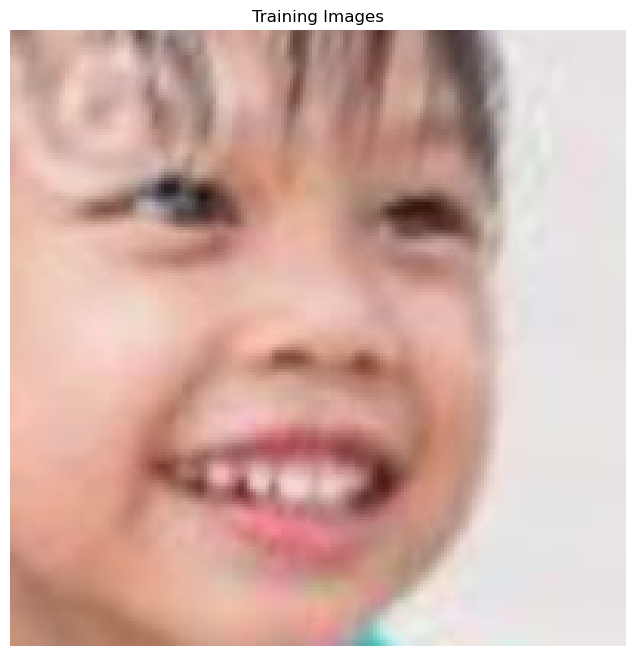

In [4]:
# Plot some training images
images, label = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(images.shape)
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()

In [19]:
class Encoder(nn.Module):
    def __init__(self, z):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 6, stride=2)
        self.conv2 = nn.Conv2d(16, 8, 4, stride=2)
        self.conv3 = nn.Conv2d(8, 4, 4, stride=2)
        self.fc1 = nn.Linear(2116, z)
        self.fc2 = nn.Linear(z, z)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.leaky_relu(x)
        x = self.conv2(x)
        x = nn.functional.leaky_relu(x)
        x = self.conv3(x)
        x = nn.functional.leaky_relu(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, z):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(16, 3, 6, stride=2)
        self.conv2 = nn.ConvTranspose2d(8, 16, 4, stride=2)
        self.conv3 = nn.ConvTranspose2d(4, 8, 4, stride=2)
        self.fc1 = nn.Linear(z, 2116)
        self.fc2 = nn.Linear(z, z)

    def forward(self, x):
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc1(x)
        x = x.reshape(batch_size, 4, 23, 23)

        x = nn.functional.leaky_relu(x)
        x = self.conv3(x)
        x = nn.functional.leaky_relu(x)
        x = self.conv2(x)
        x = nn.functional.leaky_relu(x)
        x = self.conv1(x)
        
        return x
    

class Autoencoder(nn.Module):
    def __init__(self, z):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(z)
        self.decoder = Decoder(z)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [20]:
model = Autoencoder(256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
history = []

train_batches = 100
valid_batches = 20
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    total_train_loss = 0
    for batch in range(train_batches):
        images, labels = next(data_iter)

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        recon = model(images)

        loss = criterion(images, recon)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch_size
    
    train_loss = total_train_loss / (batch_size * train_batches)
    print("Train loss:", train_loss)

    total_valid_loss = 0
    for batch in range(train_batches, train_batches+valid_batches):
        images, labels = next(data_iter)

        images = images.to(device)
        labels = labels.to(device)

        recon = model(images)

        loss = criterion(images, recon)

        total_valid_loss += loss.item() * batch_size

    valid_loss = total_valid_loss / (batch_size * valid_batches)
    print("Valid loss:", valid_loss)

    if (len(history) >= patience and valid_loss > history[-patience][1]):
        break

    history.append((train_loss, valid_loss))
    

Train loss: 0.14482149004936218
Valid loss: 0.052369038388133046
Train loss: 0.04827912051230669
Valid loss: 0.045371944271028045
Train loss: 0.04519672766327858
Valid loss: 0.043555413372814655
Train loss: 0.03825891360640526
Valid loss: 0.033749275375157595
Train loss: 0.031741002202034
Valid loss: 0.030082250852137803
Train loss: 0.029420992080122232
Valid loss: 0.029658916965126993
Train loss: 0.028051155041903256
Valid loss: 0.027515177708119155
Train loss: 0.027609184216707945
Valid loss: 0.025936177652329206
Train loss: 0.025258301123976708
Valid loss: 0.02382743079215288
Train loss: 0.02326050812378526
Valid loss: 0.02232182854786515
Train loss: 0.021715201074257492
Valid loss: 0.02085895147174597
Train loss: 0.020561212245374917
Valid loss: 0.020597688388079405
Train loss: 0.01980914835818112
Valid loss: 0.019605287164449692
Train loss: 0.018916664449498057
Valid loss: 0.01877263830974698
Train loss: 0.01801806893199682
Valid loss: 0.017022315924987198
Train loss: 0.0174692948

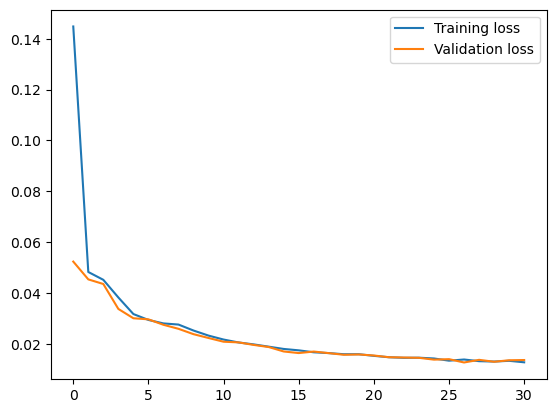

In [21]:
plt.plot(history)
plt.legend(["Training loss", "Validation loss"])
plt.show()

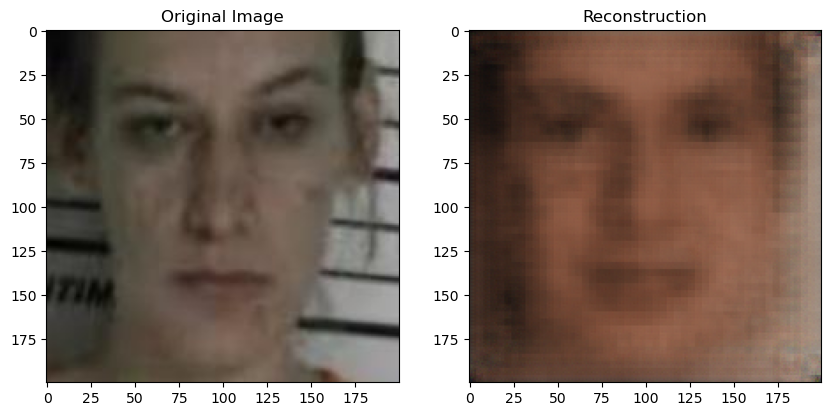

In [47]:
# Plot some training images
images, label = next(data_iter)
plt.figure(figsize=(10,5))
plt.axis("off")
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))

with torch.no_grad():
    recon = model(images.to(device))

plt.subplot(1,2,2)
plt.title("Reconstruction")
plt.imshow(np.transpose(vutils.make_grid(recon[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()